# **Loading Data**

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
train_data.shape

(42000, 785)

# **Preprocessing**

In [3]:
X = train_data.drop(['label'], axis=1)
y = train_data['label']
X_test = test_data

mean = X.mean(axis=0)
std = X.std(axis=0) + 1e-10

X_norm = (X - mean)/std
X_test_norm = (X_test - mean)/std

In [139]:
train_X_np = np.asarray(X_norm)
train_y_np = np.asarray(y).reshape(-1,1)
test_X_np = np.asarray(X_test_norm)

print(train_y_np.shape)
print(train_X_np.shape)

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    if np.isnan(x).any():
        raise ValueError("Input contains NaN values")
    return np.maximum(0, x)
def softmax(x):
    # Handle NaN values
    if np.isnan(x).any():
        raise ValueError("Input contains NaN values")
    # x shape (m, num_classes)
    ex = np.exp(x - np.max(x, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

# **Regression Neural Net From Scratch**

In [141]:
m = X_norm.shape[0]
input_dim = 784
hidden1 = 128
hidden2 = 64
num_classes = 1

In [142]:
rng = np.random.RandomState(42)
w1 = rng.randn(input_dim, hidden1) * 0.01
b1 = np.zeros((1, hidden1))
w2 = rng.randn(hidden1, hidden2) * 0.01
b2 = np.zeros((1, hidden2))
w3 = rng.randn(hidden2, num_classes) * 0.01
b3 = np.zeros((1, num_classes))

In [143]:
alpha = 0.05
epochs = 100
# Neural Network (This cell takes a lot of time to run)
for epoch in range(epochs):
    # Forward Pass
    Z1 = np.dot(train_X_np, w1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, w2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, w3) + b3
    A3 = relu(Z3)

    # Backward Propagation
    dz3 = (A3 - train_y_np) / m
    dw3 = np.dot(A2.T, dz3)
    db3 = np.sum(dz3, axis=0, keepdims=True)
    dz2 = np.dot(dz3, w3.T) * (A2 > 0)
    dw2 = np.dot(A1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)
    dz1 = np.dot(dz2, w2.T) * (A1 > 0)
    dw1 = np.dot(train_X_np.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    w3 = w3 - alpha * dw3
    b3 = b3 - alpha * db3

In [144]:
Z1 = np.dot(test_X_np, w1) + b1
A1 = relu(Z1)
Z2 = np.dot(A1, w2) + b2
A2 = relu(Z2)
Z3 = np.dot(A2, w3) + b3
y_predicted = relu(Z3)

In [145]:
test_preds = y_predicted
test_preds = test_preds.reshape(-1)

test_labels = np.rint(test_preds).astype(int)
test_labels = np.clip(test_labels, 0, 9)

In [146]:
submission['Label'] = test_labels
submission.to_csv('submission_regression_round.csv', index=False)
submission

# **Classification Neural Net From Scratch**

In [147]:
m = X_norm.shape[0]
input_dim = 784
hidden1 = 128
hidden2 = 64
num_classes = 10

In [148]:
y_onehot = np.eye(num_classes)[y]  

In [149]:
# He Init
rng = np.random.RandomState(42)
w1 = rng.randn(input_dim, hidden1) * np.sqrt(2/input_dim)
b1 = np.zeros((1, hidden1))
w2 = rng.randn(hidden1, hidden2) * np.sqrt(2/hidden1)
b2 = np.zeros((1, hidden2))
w3 = rng.randn(hidden2, num_classes) * np.sqrt(2/hidden2)
b3 = np.zeros((1, num_classes))

In [150]:
alpha = 0.0001
epochs = 202
loss = []
acc = []

# Neural Network (This cell takes a lot of time to run)
for epoch in range(epochs):
    # Forward Pass
    Z1 = np.dot(train_X_np, w1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, w2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, w3) + b3
    A3 = softmax(Z3)

    # Loss (categorical cross-entropy)
    eps = 1e-12
    l = -np.sum(y_onehot * np.log(A3 + eps)) / m
    loss.append(l)
    preds = np.argmax(A3, axis=1)
    a = (preds == y).mean()
    acc.append(a)
    if epoch%100 == 0:
        print(f"Epoch {epoch} loss={l:.4f} acc={a:.4f}")

    # Backward Propagation
    dz3 = (A3 - train_y_np) / m
    dw3 = np.dot(A2.T, dz3)
    db3 = np.sum(dz3, axis=0, keepdims=True)
    
    dz2 = np.dot(dz3, w3.T) * (A2 > 0)
    dw2 = np.dot(A1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)
    
    dz1 = np.dot(dz2, w2.T) * (A1 > 0)
    dw1 = np.dot(train_X_np.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    np.clip(dw1, -1.0, 1.0, out=dw1)
    np.clip(db1, -1.0, 1.0, out=db1)
    np.clip(dw2, -1.0, 1.0, out=dw2)
    np.clip(db2, -1.0, 1.0, out=db2)
    np.clip(dw3, -1.0, 1.0, out=dw3)
    np.clip(db3, -1.0, 1.0, out=db3)

    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    w3 = w3 - alpha * dw3
    b3 = b3 - alpha * db3

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(range(epochs), loss, label='loss')
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(range(epochs), acc, label='accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [153]:
Z1 = np.dot(test_X_np, w1) + b1
A1 = relu(Z1)
Z2 = np.dot(A1, w2) + b2
A2 = relu(Z2)
Z3 = np.dot(A2, w3) + b3
A3 = softmax(Z3)

In [154]:
test_labels = np.argmax(A3, axis=1)
submission['Label'] = test_labels
submission.to_csv('submission_softmax.csv', index=False)
submission

# **Deep Neural Net With Keras**

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

X_sc = X/255
X_test_sc = X_test/255

In [24]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[784]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [26]:
history = model.fit(
    X_sc, y, 
    batch_size=128, 
    epochs=20, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7524 - loss: 0.8181 - val_accuracy: 0.9499 - val_loss: 0.1916
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9398 - loss: 0.2086 - val_accuracy: 0.9631 - val_loss: 0.1153
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9558 - loss: 0.1472 - val_accuracy: 0.9683 - val_loss: 0.1070
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1317 - val_accuracy: 0.9690 - val_loss: 0.1021
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9687 - loss: 0.1064 - val_accuracy: 0.9719 - val_loss: 0.0970
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9715 - loss: 0.0948 - val_accuracy: 0.9723 - val_loss: 0.0952
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9751 - loss: 0.0811 - val_accuracy: 0.9750 - val_loss: 0.0837
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9761 - loss: 0.0743 - val_accuracy: 0

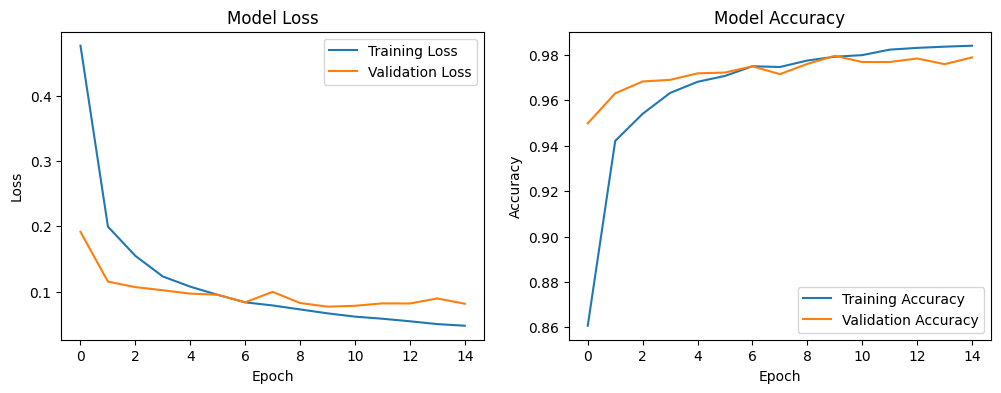

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [29]:
probas = model.predict(X_test_sc)
preds = np.argmax(probas, axis=1)
submission['Label'] = preds
submission.to_csv('submission_keras_dense.csv', index=False)
# Test Accuracy: 0.97560
submission

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# **ConvNet Keras**

In [30]:
X_sc = X/255
X_test_sc = X_test/255

In [168]:
model = keras.Sequential([
    layers.Input(shape=[784]),
    layers.Reshape((28,28,1)),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

In [169]:
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True
)

In [170]:
history = model.fit(
    X_sc, y_t, 
    batch_size=128, 
    epochs=6, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9061 - loss: 0.3277 - val_accuracy: 0.7056 - val_loss: 1.0584
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9876 - loss: 0.0433 - val_accuracy: 0.9856 - val_loss: 0.0676
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9931 - loss: 0.0233 - val_accuracy: 0.9877 - val_loss: 0.0442
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9959 - loss: 0.0155 - val_accuracy: 0.9863 - val_loss: 0.0426
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9867 - val_loss: 0.0465
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9978 - loss: 0.0083 - val_accuracy: 0.9890 - val_loss: 0.0381
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9879 - val_loss: 0.0432
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9978 - loss: 0.0065 - 

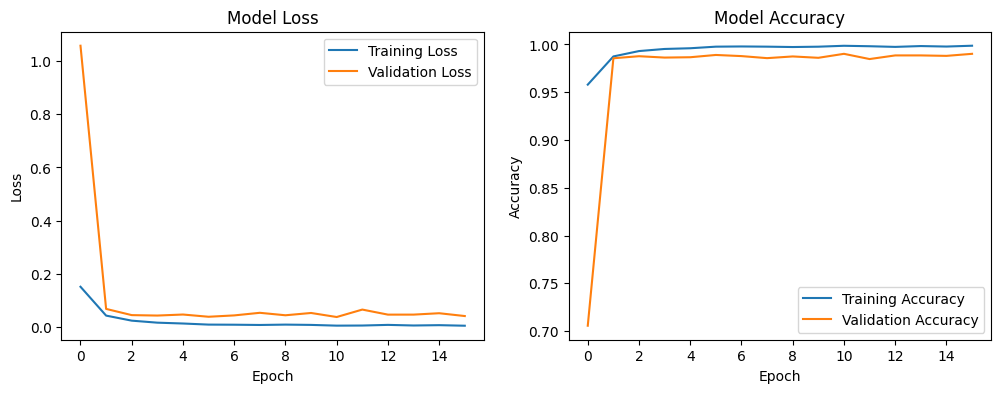

In [171]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [173]:
probas = model.predict(X_test_sc)
preds = np.argmax(probas, axis=1)
submission['Label'] = preds
submission.to_csv('submission_keras_cnn.csv', index=False)
# Test Accuracy: 0.98807
submission

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# **Keras CNN with Data Augumentation**

Replacing `Conv2D(..., activation='relu')` with `Conv2D(..., use_bias=False) → BatchNormalization() → Activation('relu')`. Doing the same for Dense layers (Dense → BatchNorm → Activation) and set `use_bias=False` when using BN.

More conv filters (32→64→128), two conv layers per block. 
Using `GlobalAveragePooling2D()` before Dense (fewer params). 
Adding `Dropout(0.2–0.4)` before the final dense layer. 
Using `kernel_initializer='he_normal'`.

Data augmentation: small shifts/rotations (no heavy distortions). 
Adam optimizer with LR schedule: starting from 1e-3 (`ReduceLROnPlateau` or `CosineDecay`). 
Training longer (20–50 epochs) with `EarlyStopping(patience=6, restore_best_weights=True)`. 
Doing `label_smoothing=0.01` in CategoricalCrossentropy for extra robustness.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
model = keras.Sequential([
    layers.Input(shape=[784]),
    layers.Reshape((28,28,1)),
    layers.Rescaling(1./255),                       # scale inside model
    layers.RandomRotation(0.06),
    layers.RandomTranslation(0.06, 0.06),

    # Block 1
    layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, use_bias=False, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.001,
        patience=6, 
        restore_best_weights=True)
]

In [10]:
history = model.fit(
    X, y, 
    batch_size=128, 
    epochs=30, 
    validation_split=0.1, 
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1766922893.973231     126 cuda_dnn.cc:529] Loaded cuDNN version 91002


296/296 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7873 - loss: 0.6852 - val_accuracy: 0.9519 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9695 - loss: 0.1045 - val_accuracy: 0.9869 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9769 - loss: 0.0749 - val_accuracy: 0.8864 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9827 - loss: 0.0606 - val_accuracy: 0.9802 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9845 - loss: 0.0516 - val_accuracy: 0.9752 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9875 - loss: 0.0433 - val_accuracy: 0.9905 - val_loss: 0.0330 - learning_rate: 5.0000e-04
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9905 - loss: 0.0327 -

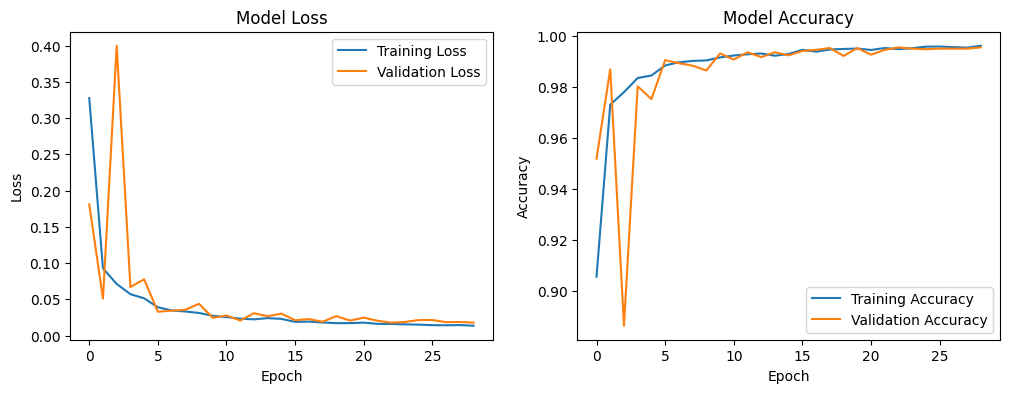

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
probas = model.predict(X_test)
preds = np.argmax(probas, axis=1)
submission['Label'] = preds
submission.to_csv('submission_keras_best_cnn.csv', index=False)
# Test Accuracy: 0.99350
submission

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# **Ensembling**
Train 2–3 models with different seeds/architectures and average predictions. \
Test-time augmentation (simple flips/rotations) and average — gives +0.1–0.3% typical gains.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
n_folds = 3
base = 42

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.001,
        patience=6, 
        restore_best_weights=True)
]

def cnn_model():
    return keras.Sequential([
        layers.Input(shape=[784]),
        layers.Reshape((28,28,1)),
        layers.Rescaling(1./255),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.06, 0.06),
    
        # Block 1
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
    
        # Block 2
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
    
        # Block 3
        layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, 4, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
    
        layers.Flatten(),
        layers.Dense(128, use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.25),
        layers.Dense(64, use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])

In [18]:
import tensorflow as tf

preds_list = []

for i in range(n_folds):
    seed = base + i
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = cnn_model()
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n--- Training model {i+1}/{n_folds} (seed={seed}) ---")
    history = model.fit(
        X, y, 
        batch_size=128, 
        epochs=45, 
        validation_split=0.1, 
        callbacks=callbacks,
        verbose = 0
    )

    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(i+1,len(history.epoch),max(history.history['accuracy']),max(history.history['val_accuracy']) ))

    probs = model.predict(X_test, verbose=0)
    preds_list.append(probs)


--- Training model 1/3 (seed=42) ---
CNN 1: Epochs=42, Train accuracy=0.99317, Validation accuracy=0.99405

--- Training model 2/3 (seed=43) ---
CNN 2: Epochs=29, Train accuracy=0.99116, Validation accuracy=0.99143

--- Training model 3/3 (seed=44) ---
CNN 3: Epochs=38, Train accuracy=0.99320, Validation accuracy=0.99024


In [19]:
avg_probs = np.mean(np.stack(preds_list, axis=0), axis=0)
final_preds = np.argmax(avg_probs, axis=1)

submission['Label'] = final_preds
submission.to_csv('submission_cnn_ensemble.csv', index=False)
# Without TTA
# Test Accuracy: 0.99417 with 15 folds
# Test Accuracy: 0.99471 with 3 folds
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# **DeepNet Using PyTorch**

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

X = X.values.astype(np.float32) / 255.0
y = y.values.astype(np.int64)
X_test = X_test.values.astype(np.float32) / 255.0

In [7]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X, y)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)

# Model
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # logits
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()  # expects logits & integer labels
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    print(f"Epoch {epoch} loss={total_loss/total:.4f} acc={correct/total:.4f}")

Epoch 0 loss=0.3710 acc=0.8932
Epoch 1 loss=0.1436 acc=0.9565
Epoch 2 loss=0.0993 acc=0.9695
Epoch 3 loss=0.0751 acc=0.9764
Epoch 4 loss=0.0608 acc=0.9802
Epoch 5 loss=0.0457 acc=0.9860
Epoch 6 loss=0.0392 acc=0.9868
Epoch 7 loss=0.0320 acc=0.9898
Epoch 8 loss=0.0274 acc=0.9908
Epoch 9 loss=0.0243 acc=0.9924
Epoch 10 loss=0.0225 acc=0.9921
Epoch 11 loss=0.0207 acc=0.9931
Epoch 12 loss=0.0176 acc=0.9941
Epoch 13 loss=0.0184 acc=0.9933
Epoch 14 loss=0.0161 acc=0.9942
Epoch 15 loss=0.0165 acc=0.9942
Epoch 16 loss=0.0151 acc=0.9951
Epoch 17 loss=0.0130 acc=0.9955
Epoch 18 loss=0.0120 acc=0.9959
Epoch 19 loss=0.0134 acc=0.9954


In [9]:
# Predict on test
model.eval()
test_tensor = torch.from_numpy(X_test).float().to(device)
with torch.no_grad():
    logits = model(test_tensor)
    preds = logits.argmax(dim=1).cpu().numpy()

submission['Label'] = preds
submission.to_csv('submission_pytorch.csv', index=False)
# Test Accuracy: 0.97750
print("Saved submission_pytorch.csv")

Saved submission_pytorch.csv
